In [2]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import graphviz
import pydot

from IPython.display import Image

%matplotlib inline

In [3]:
data_train = np.loadtxt('hw4-kernels/svm-train.txt')
data_test = np.loadtxt('hw4-kernels/svm-test.txt')
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

In [4]:
# Change target to 0-1 label
y_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train))).reshape(-1, 1)

In [5]:
class Decision_Tree(BaseEstimator):
     
    def __init__(self, split_loss_function, leaf_value_estimator,
                 depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier

        :param split_loss_function: method for splitting node
        :param leaf_value_estimator: method for estimating leaf value
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth
        self.is_leaf = None
        self.split_id = None
        self.split_value = None
        self.left = None
        self.right = None
        self.value = None
        self.loss = None
        
    def fit(self, X, y=None):
        '''
        This should fit the tree classifier by setting the values self.is_leaf, 
        self.split_id (the index of the feature we want ot split on, if we're splitting),
        self.split_value (the corresponding value of that feature where the split is),
        and self.value, which is the prediction value if the tree is a leaf node.  If we are 
        splitting the node, we should also init self.left and self.right to be Decision_Tree
        objects corresponding to the left and right subtrees. These subtrees should be fit on
        the data that fall to the left and right,respectively, of self.split_value.
        This is a recurisive tree building procedure. 
        
        :param X: a numpy array of training data, shape = (n, m)
        :param y: a numpy array of labels, shape = (n, 1)

        :return self
        '''
        #If depth is max depth turn into leaf
        if self.depth == self.max_depth:
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            return self
        #If reach minimun sample size turn into leaf
        if len(y)<=self.min_sample:
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            return self
        #If not is_leaf, i.e in the node, we should create left and right subtree
        #But First we need to decide the self.split_id and self.split_value that minimize loss
        #Compare with constant prediction of all X
        loss_before = self.split_loss_function(y)
        best_split_value = None
        best_split_id = None
        best_loss = self.split_loss_function(y)
        best_left_X = None
        best_right_X = None
        best_left_y = None
        best_right_y = None
        best_pos = None
        #Concatenate y into X for sorting together
        X = np.concatenate([X,y],1)
        for i in range(X.shape[1]-1): 
            #Note: The last column of X is y now
            X = np.array(sorted(X,key=lambda x:x[i]))
            for split_pos in range(len(X)-1):
                #:split_pos+1 will include the split_pos data in left_X
                left_X = X[:split_pos+1,:-1]
                right_X = X[split_pos+1:,:-1]
                #you need left_y to be in (n,1) i.e (-1,1) dimension
                left_y = X[:split_pos+1,-1].reshape(-1,1)
                right_y = X[split_pos+1:,-1].reshape(-1,1)
                left_loss = len(left_y)*self.split_loss_function(left_y)/len(y)
                right_loss = len(right_y)*self.split_loss_function(right_y)/len(y)
                #If any choice of splitting feature and splitting position results in better loss
                #record following information and discard the old one
                if ((left_loss+right_loss)<best_loss):
                    best_split_value = X[split_pos,i]
                    best_pos = split_pos
                    best_split_id = i
                    best_loss = left_loss+right_loss
                    best_left_X = left_X
                    best_right_X = right_X
                    best_left_y = left_y
                    best_right_y = right_y
        #Condition when you have a split position that results in better loss
        if best_split_id!=None:
            self.left = Decision_Tree(self.split_loss_function,self.leaf_value_estimator,self.depth+1\
                                      ,self.min_sample,self.max_depth)
            self.right = Decision_Tree(self.split_loss_function,self.leaf_value_estimator,self.depth+1\
                                       ,self.min_sample,self.max_depth)
            self.left.fit(best_left_X,best_left_y)
            self.right.fit(best_right_X,best_right_y)
            self.split_id = best_split_id
            self.split_value = best_split_value
            self.loss = best_loss
        else: 
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
        
        #print(self.split_id, self.split_value)
        return self

    def predict_instance(self, instance):
        '''
        Predict label by decision tree

        :param instance: a numpy array with new data, shape (1, m)

        :return whatever is returned by leaf_value_estimator for leaf containing instance
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            #print('split at x[%s]<=%s'%(self.split_id,self.split_value))
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

# Classification tree

In [6]:
def compute_entropy(label_array):
    '''
    Calulate the entropy of given label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return entropy: entropy value
    '''
    n_classes = np.unique(label_array)
    entropy = 0
    for label in n_classes:
        p = np.sum(label_array==label)/float(len(label_array))
        entropy += -p*np.log(p)
    return entropy

def compute_gini(label_array):
    '''
    Calulate the gini index of label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    '''
    n_classes = np.unique(label_array)
    gini = 0
    for label in n_classes:
        p = np.sum(label_array==label)/len(label_array)
        gini += p*(1-p)
    return gini

In [7]:
def most_common_label(y):
    '''
    Find most common label
    '''
    label_cnt = Counter(y.reshape(len(y)))
    label = label_cnt.most_common(1)[0][0]
    return label

In [8]:
class Classification_Tree(BaseEstimator, ClassifierMixin):

    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }

    def __init__(self, loss_function='gini', min_sample=5, max_depth=10):
        '''
        :param loss_function(str): loss function for splitting internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                most_common_label,
                                0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

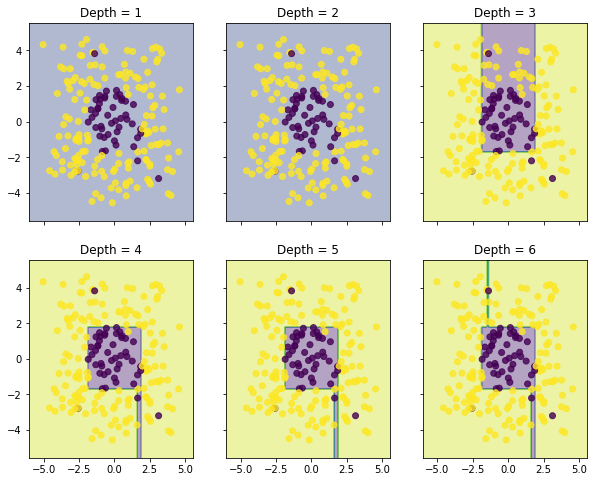

In [16]:
# Training classifiers with different depth
clf1 = Classification_Tree(max_depth=1)
clf1.fit(x_train, y_train_label)

clf2 = Classification_Tree(max_depth=2)
clf2.fit(x_train, y_train_label)

clf3 = Classification_Tree(max_depth=3)
clf3.fit(x_train, y_train_label)

clf4 = Classification_Tree(max_depth=4)
clf4.fit(x_train, y_train_label)

clf5 = Classification_Tree(max_depth=5)
clf5.fit(x_train, y_train_label)

clf6 = Classification_Tree(max_depth=20)
clf6.fit(x_train, y_train_label)

# Plotting decision regions
x1_min, x1_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
x2_min, x2_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.1),
                     np.arange(x2_min, x2_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx1.ravel(), xx2.ravel()]])
    Z = Z.reshape(xx1.shape)

    axarr[idx[0], idx[1]].contourf(xx1, xx2, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0].reshape(-1,1), x_train[:, 1].reshape(-1,1), c = y_train_label, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

In [10]:
# compare decision tree with tree model in sklearn
clf = DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_split=5)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

In [11]:
!dot -Tpng tree_classifier.dot -o tree_classifier.png

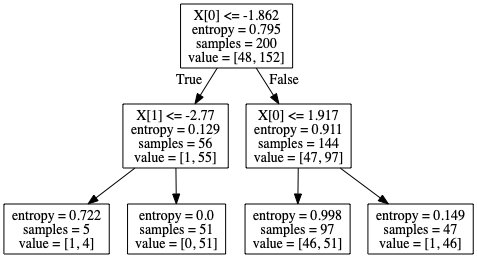

In [12]:
Image(filename='tree_classifier.png')

# Regression tree

In [18]:
def mean_absolute_deviation_around_median(y):
    '''
    Calulate the mean absolute deviation around the median of a given target list
    
    :param y: a numpy array of targets shape = (n, 1)
    :return mae
    '''
    # Your code goes here
    median = np.median(y)
    mae = np.mean(np.abs(y-median))
    return mae

In [20]:
class Regression_Tree():
    '''
    :attribute loss_function_dict: dictionary containing the loss functions used for splitting
    :attribute estimator_dict: dictionary containing the estimation functions used in leaf nodes
    '''

    loss_function_dict = {
        'mse': np.var,
        'mae': mean_absolute_deviation_around_median
    }

    estimator_dict = {
        'mean': np.mean,
        'median': np.median
    }
    
    def __init__(self, loss_function='mse', estimator='mean', min_sample=5, max_depth=10):
        '''
        Initialize Regression_Tree
        :param loss_function(str): loss function used for splitting internal nodes
        :param estimator(str): value estimator of internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  self.estimator_dict[estimator],
                                  0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self
    
    def predict_instance(self, instance):
        prediction = self.tree.predict_instance(instance)
        return prediction

In [21]:
# load a one-dimensional data
data_krr_train = np.loadtxt('hw4-kernels/krr-train.txt')
data_krr_test = np.loadtxt('hw4-kernels/krr-test.txt')
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1),data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1),data_krr_test[:,1].reshape(-1,1)

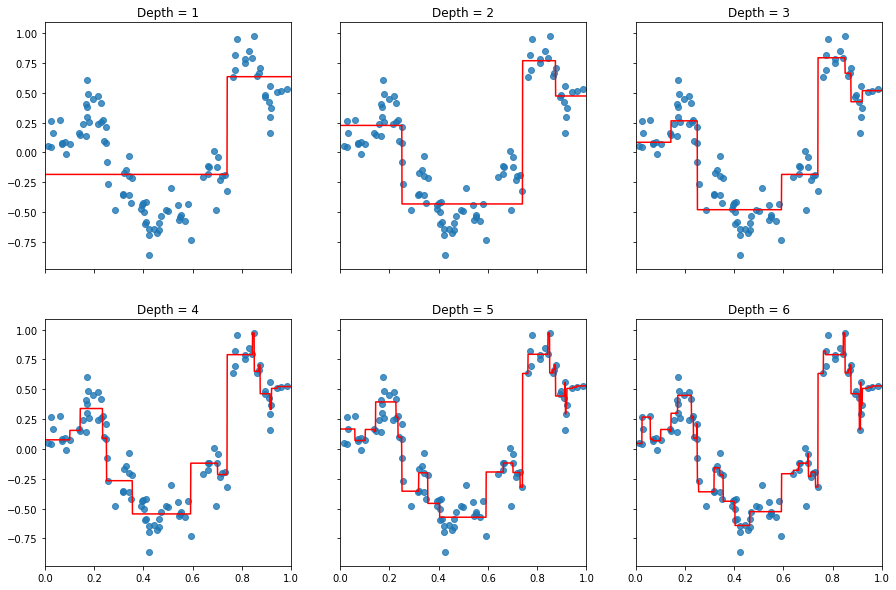

In [28]:
# Training regression trees with different depth (MAE)
clf1 = Regression_Tree(max_depth=1,  min_sample=1, loss_function='mae', estimator='median')
clf1.fit(x_krr_train, y_krr_train)

clf2 = Regression_Tree(max_depth=2,  min_sample=1, loss_function='mae', estimator='median')
clf2.fit(x_krr_train, y_krr_train)

clf3 = Regression_Tree(max_depth=3,  min_sample=1, loss_function='mae', estimator='median')
clf3.fit(x_krr_train, y_krr_train)

clf4 = Regression_Tree(max_depth=4,  min_sample=1, loss_function='mae', estimator='median')
clf4.fit(x_krr_train, y_krr_train)

clf5 = Regression_Tree(max_depth=5,  min_sample=1, loss_function='mae', estimator='median')
clf5.fit(x_krr_train, y_krr_train)

clf6 = Regression_Tree(max_depth=6,  min_sample=1, loss_function='mae', estimator='median')
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()

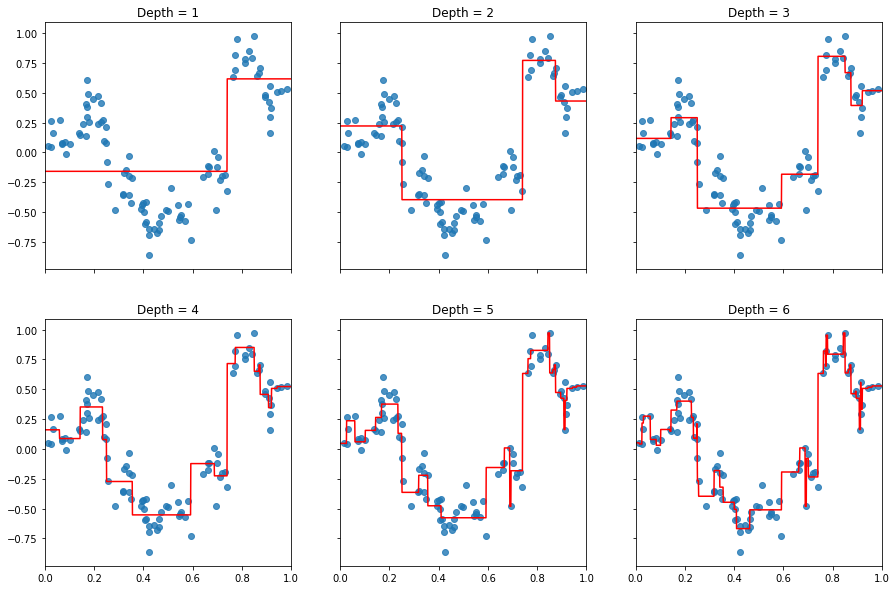

In [30]:
# Training regression trees with different depth (MSE)
clf1s = Regression_Tree(max_depth=1,  min_sample=1, loss_function='mse', estimator='mean')
clf1s.fit(x_krr_train, y_krr_train)

clf2s = Regression_Tree(max_depth=2,  min_sample=1, loss_function='mse', estimator='mean')
clf2s.fit(x_krr_train, y_krr_train)

clf3s = Regression_Tree(max_depth=3,  min_sample=1, loss_function='mse', estimator='mean')
clf3s.fit(x_krr_train, y_krr_train)

clf4s = Regression_Tree(max_depth=4,  min_sample=1, loss_function='mse', estimator='mean')
clf4s.fit(x_krr_train, y_krr_train)

clf5s = Regression_Tree(max_depth=5,  min_sample=1, loss_function='mse', estimator='mean')
clf5s.fit(x_krr_train, y_krr_train)

clf6s = Regression_Tree(max_depth=6,  min_sample=1, loss_function='mse', estimator='mean')
clf6s.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1s, clf2s, clf3s, clf4s, clf5s, clf6s],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()

In [105]:
def pseudo_residual_L2(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    residual = (train_target - train_predict)
    return residual

def pseudo_residual_logistic(train_target,train_predict):
    y = train_target
    fx = train_predict
    m = y*fx
    return (y*np.exp(-m))/(1+np.exp(-m))

In [112]:
class gradient_boosting():
    '''
    Gradient Boosting regressor class
    :method fit: fitting model
    '''
    def __init__(self, n_estimator, pseudo_residual_func,\
                 learning_rate=0.1, min_sample=5, max_depth=3):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual
        :param learning_rate: step size of gradient descent
        '''
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth
        
        self.base_models = []
        self.f0 = None

    def fit(self, train_data, train_target):
        '''
        Fit gradient boosting model
        '''
        self.f0 = Regression_Tree(loss_function='mse', estimator='mean',
                                  min_sample=self.min_sample, max_depth=self.max_depth)
        self.f0.fit(train_data, train_target)
        step_prediction = np.zeros(len(train_data)).reshape(-1,1)
        for n in range(self.n_estimator):
            if len(self.base_models) == 0:
                for i in range(len(train_data)):
                    step_prediction[i] = self.f0.predict_instance(train_data[i])
                residual = self.pseudo_residual_func(train_target, step_prediction)
            else:
                for i in range(len(train_data)):
                    step_prediction[i] += self.learning_rate * base_model.predict_instance(train_data[i])
                residual = self.pseudo_residual_func(train_target, step_prediction)
            base_model = Regression_Tree(loss_function='mse', estimator='mean', min_sample=self.min_sample, max_depth=self.max_depth)
            base_model.fit(train_data, residual)
            self.base_models.append(base_model)
            
    def predict(self, test_data):
        '''
        Predict value
        '''
        prediction = self.f0.predict_instance(test_data)
        for base_model in self.base_models:
            prediction += self.learning_rate * base_model.predict_instance(test_data)
        return prediction

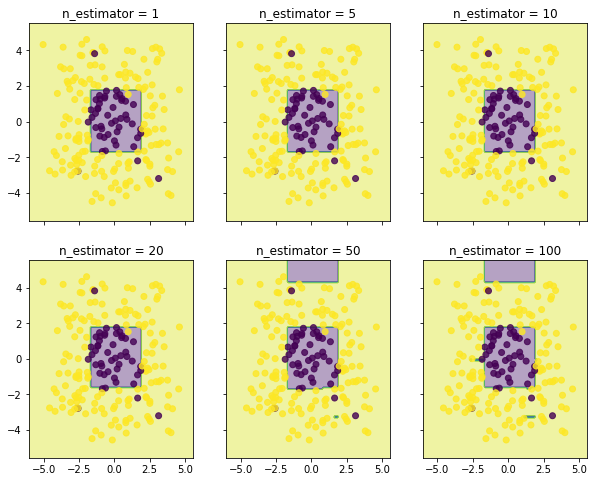

In [113]:
# Plotting decision regions (l2 residual)
x1_min, x1_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
x2_min, x2_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.1),
                     np.arange(x2_min, x2_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbt = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, max_depth=2,learning_rate=0.1)  
    gbt.fit(x_train, y_train)
                   
    Z = np.sign([gbt.predict(x) for x in np.c_[xx1.ravel(), xx2.ravel()]])
    Z = Z.reshape(xx1.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label.reshape(-1), alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

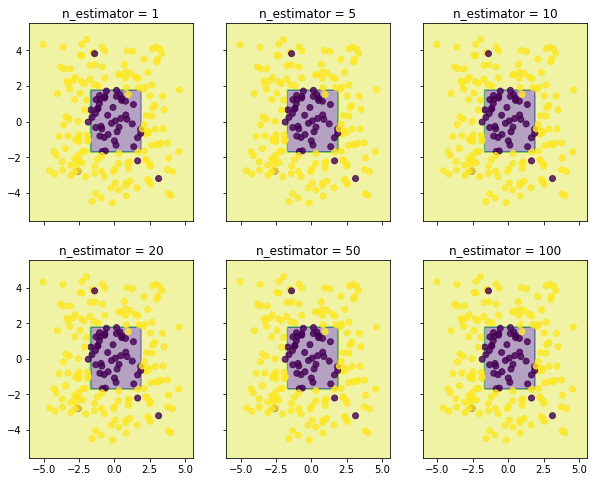

In [101]:
# Plotting decision regions (logistic residual)
x1_min, x1_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
x2_min, x2_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.1),
                     np.arange(x2_min, x2_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbt = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_logistic, max_depth=2,learning_rate=0.1)  
    gbt.fit(x_train, y_train)
                   
    Z = np.sign([gbt.predict(x) for x in np.c_[xx1.ravel(), xx2.ravel()]])
    Z = Z.reshape(xx1.shape)

    axarr[idx[0], idx[1]].contourf(xx1, xx2, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label.reshape(-1), alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

In [83]:
data_krr_train = np.loadtxt('hw4-kernels/krr-train.txt')
data_krr_test = np.loadtxt('hw4-kernels/krr-test.txt')
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1),data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1),data_krr_test[:,1].reshape(-1,1)

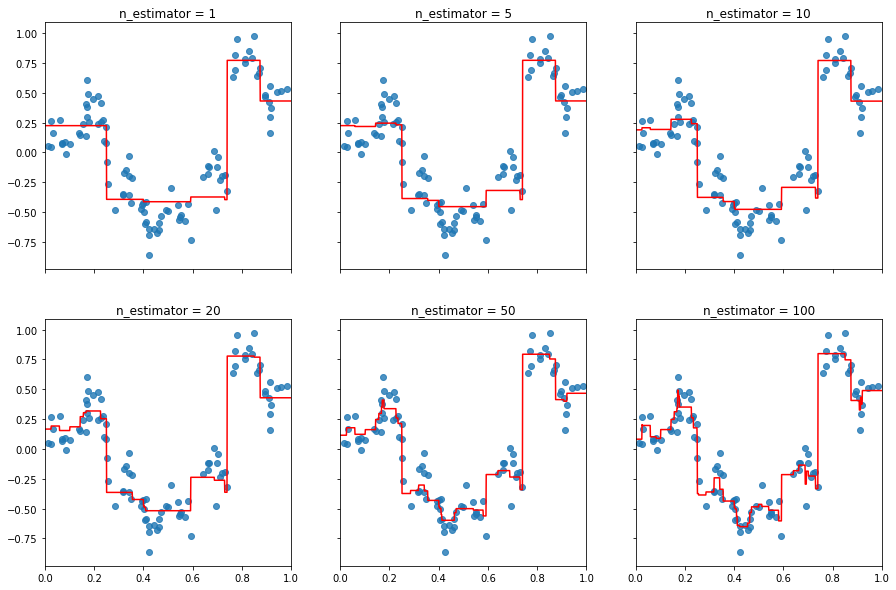

In [119]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, max_depth=2,learning_rate=0.1)  
    gbm_1d.fit(x_krr_train, y_krr_train)
    
    y_range_predict = [gbm_1d.predict(x) for x in x_range]

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)